# Tutorial: Entendimiento de los datos con PySpark

Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
%matplotlib notebook 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#plt.rcParams['figure.max_open_warning'] = 30  # or any other number 
#matplotlib.use('TkAgg')  # Usando el backend TkAgg

Configuración del controlador e inicio de sesion Spark

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_67_202315'
db_psswd = 'aabb1122'

PATH='./'

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [6]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

### Completitud y validez

In [37]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados 

# Checking "" values 
def contar_vacios_str(df, printing = True):
    resultados = []
    for c in df.columns:
        vacios = df.filter((df[c] == "")).count()
        if vacios != 0: 
            if printing: 
                print('Number of "" values for column ' + c + ': ' + str(vacios))
            resultados.append(vacios)
    return resultados 


def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

# 5. Tarea
Espacio para desarrollar la tarea propuesta 

#### Cargue de tablas

#### Entendimiento general de datos

In [40]:
# Getting Df from WWImportersTransactional.movimientosCopia 
sql_FuenteAreasDeServicio_Copia_E = 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E'
sql_FuenteCondicionesDePago_Copia_E = 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E'
sql_FuenteTiposBeneficio_Copia_E = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'
sql_movimientosCopia = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'

movimientosCopia = obtener_dataframe_de_bd(db_connection_string, sql_movimientosCopia, db_user, db_psswd) 
FuenteAreasDeServicio_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteAreasDeServicio_Copia_E, db_user, db_psswd) 
FuenteCondicionesDePago_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteCondicionesDePago_Copia_E, db_user, db_psswd)  
FuenteTiposBeneficio_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteTiposBeneficio_Copia_E, db_user, db_psswd)   
# Exploring the table 
movimientosCopia.show(5) 

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

## 1. Completitud del perfilamiento de datos 
### Cantidad de registros y cantidad de columnas por tipo de dato

### Tabla FuentePlanesBeneficio_Copia_E 

In [9]:
# Getting each column's type 
print("Columns' type") 
print(movimientosCopia.schema) 
# Printing df's dimensions 
print("\n Df's dimensions") 
print((movimientosCopia.count(), len(movimientosCopia.columns))) 

Columns' type
StructType(List(StructField(IdTipoBeneficio_T,LongType,true),StructField(IdAreaDeServicio_T,LongType,true),StructField(IdCondicionDePagoCopago_T,IntegerType,true),StructField(IdCondicionDePagoCoseguro_T,IntegerType,true),StructField(IdNivelServicio_T,IntegerType,true),StructField(IdPlan_T,StringType,true),StructField(Fecha,StringType,true),StructField(IdProveedor_T,IntegerType,true),StructField(valorCopago,IntegerType,true),StructField(valorCoseguro,IntegerType,true),StructField(cantidadLimite,IntegerType,true)))

 Df's dimensions
(36036, 11)


### Tabla FuenteAreasDeServicio_Copia_E

In [59]:
# Getting each column's type 
print("Columns' type") 
print(FuenteAreasDeServicio_Copia_E.schema) 
# Printing df's dimensions 
print("\n Df's dimensions") 
print((FuenteAreasDeServicio_Copia_E.count(), len(FuenteAreasDeServicio_Copia_E.columns))) 

Columns' type
StructType(List(StructField(IdAreaDeServicio_T,IntegerType,true),StructField(NombreAreaDeServicio,StringType,true),StructField(IdGeografia_T,IntegerType,true),StructField(Condado,StringType,true),StructField(Estado,StringType,true),StructField(PoblacionAct,DoubleType,true),StructField(Area,DoubleType,true),StructField(Densidad,DoubleType,true),StructField(Fecha,IntegerType,true)))

 Df's dimensions
(188815, 9)


### Tabla FuenteCondicionesDePago_Copia_E

In [58]:
# Getting each column's type 
print("Columns' type") 
print(FuenteCondicionesDePago_Copia_E.schema) 
# Printing df's dimensions 
print("\n Df's dimensions") 
print((FuenteCondicionesDePago_Copia_E.count(), len(FuenteCondicionesDePago_Copia_E.columns))) 

Columns' type
StructType(List(StructField(IdCondicionesDePago_T,IntegerType,true),StructField(Descripcion,StringType,true),StructField(Tipo,StringType,true)))

 Df's dimensions
(31, 3)


### Tabla FuenteTiposBeneficio_Copia_E

In [57]:
# Getting each column's type 
print("Columns' type") 
print(FuenteTiposBeneficio_Copia_E.schema) 
# Printing df's dimensions 
print("\n Df's dimensions") 
print((FuenteTiposBeneficio_Copia_E.count(), len(FuenteTiposBeneficio_Copia_E.columns))) 

Columns' type
StructType(List(StructField(IdTipoBeneficio_T,IntegerType,true),StructField(Nombre,StringType,true),StructField(UnidadDelLimite,StringType,true),StructField(EsEHB,StringType,true),StructField(EstaCubiertaPorSeguro,StringType,true),StructField(TieneLimiteCuantitativo,StringType,true),StructField(ExcluidoDelDesembolsoMaximoDentroDeLaRed,StringType,true),StructField(ExcluidoDelDesembolsoMaximoFueraDeLaRed,StringType,true),StructField(Fecha,IntegerType,true)))

 Df's dimensions
(849, 9)


## 2. Significado de una fila 

#### Tabla FuentePlanesBeneficio_Copia_E: 
El registro de los planes de los beneficios obtenidos a lo largo de la historia de la empresa con datos de las áreas de servicio, las condiciones de pago del coseguro y el copago, el tipo de beneficio, la cantidad limite del tipo de beneficio y el proveedor. 
#### Tabla FuenteAreasDeServicio_Copia_E: 
En resumen, esta tabla parece contener información relacionada con áreas de servicio, incluyendo detalles geográficos, datos de población, y ubicación en términos de condado y estado. Cada fila representa una entrada única en esta tabla con estos atributos.
#### Tabla FuenteCondicionesDePago_Copia_E: 
Contiene la información relacionada con diferentes condiciones de pago, incluyendo su descripción y el tipo de condición. Cada fila representa una entrada única en esta tabla con estos atributos. Estos datos pueden ser útiles en un sistema de gestión financiera o de ventas para llevar un registro de las condiciones de pago disponibles.
#### Tabla FuenteTiposBeneficio_Copia_E: 
Contiene la información sobre diferentes tipos de beneficios, incluyendo detalles sobre su nombre, unidades de medida, clasificación EHB, cobertura de seguro y otros indicadores relacionados con los beneficios de salud. Cada fila representa un tipo de beneficio único en esta tabla con estos atributos. Estos datos pueden ser relevantes en un contexto de gestión de seguros de salud o beneficios médicos.

## 3. Revisión de reglas de negocio

### Tabla FuentePlanesBeneficio_Copia_E 

In [104]:
print("\n2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.")
# Obtener los tipos de beneficio distintos que tienen TieneLimiteCuantitativo igual a 'Yes' o 'Si' desde FuenteTiposBeneficio_Copia_E
# Obtener los tipos de beneficio distintos que tienen TieneLimiteCuantitativo igual a 'Yes' o 'Si' desde FuenteTiposBeneficio_Copia_E
tipos_beneficio_distinct = FuenteTiposBeneficio_Copia_E.filter(functions.col('TieneLimiteCuantitativo').isin('Yes', 'Si')) \
    .select('IdTipoBeneficio_T').distinct()

# Filtrar FuentePlanesBeneficio_Copia_E según las condiciones especificadas
resultado = movimientosCopia \
    .filter((functions.col('IdTipoBeneficio_T').isin([row.IdTipoBeneficio_T for row in tipos_beneficio_distinct.collect()]))
            & ((functions.col('cantidadLimite') == 0) | (functions.col('cantidadLimite').isNull()))) \
    .orderBy('cantidadLimite', ascending=True)

# Mostrar los resultados
resultado.show() 
print("Esta regla se cumple dado que no hay valores en 0 en el campo CantidadLimite para aquellos beneficios con límites cuantitativos, pero se observan valores en NULL, los cuales se deben de aclarar")

# Imprimir la primera declaración
print("\n5) El valor máximo de Copago y Coinsurance para el año 2018 es respectivamente 3300 y 100 ".center(20, '*'))

# Filtrar aquellas columnas que cumplan con el formato
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumpleFormato_FT = movimientosCopia.filter(movimientosCopia["Fecha"].rlike(regex)) 

# Imprimir el número total de pedidos y el número de pedidos con formato correcto
print("\nNúmero total de pedidos: " + str(movimientosCopia.count()) + ", número de pedidos con formato correcto: " + str(cumpleFormato_FT.count()))

# Filtrar aquellas filas que no cumplen con el formato
noCumpleFormato_FT = movimientosCopia.filter(~movimientosCopia["Fecha"].rlike(regex)) 
noCumpleFormato_FT.count(), noCumpleFormato_FT.select(col("Fecha")).show() 

# Imprimir el número de filas que no cumplen con el formato correcto
print(f"Número de filas que no cumplen con el formato correcto: {noCumpleFormato_FT.count()}") 

# Verificar si hay otros tipos de valores diferentes en esta columna
print(f"Verificando si hay algunos valores diferentes en la columna: ")
movimientosCopia.where(length(col("Fecha")) <= 9).show()

# Convertir la columna "Fecha" a tipo de dato fecha
movimientosCopia = movimientosCopia.withColumn("Fecha", movimientosCopia["Fecha"].cast("date"))

# Filtrar el DataFrame para incluir solo registros del año 2018
df_2018 = movimientosCopia.filter(functions.year(movimientosCopia["Fecha"]) == 2018)

# Encontrar los valores máximos de copago y coinsurance para el año 2018
maximo_copago = df_2018.agg({"valorCopago": "max"}).collect()[0][0]
maximo_coinsurance = df_2018.agg({"valorCoseguro": "max"}).collect()[0][0]

# Imprimir los valores máximos
print(f"El valor máximo de Copago para el año 2018 es: {maximo_copago}")
print(f"El valor máximo de Coinsurance para el año 2018 es: {maximo_coinsurance}") 

# Verificar si hay algún valor por encima de 3000 cerca de 3300 
# Filtrar el DataFrame para el año 2018 y valorCopago >= 3000
filtered_df = movimientosCopia.filter((functions.year(movimientosCopia["Fecha"]) == 2018) & (movimientosCopia["valorCopago"] >= 3000))

# Realizar la agregación y seleccionar las columnas deseadas
result_df = filtered_df.groupBy("valorCopago").count()

# Imprimir el resultado 
print("Número de valorCopago y cuántas veces se repiten cuando superan los 2999")
result_df.show() 

print("""
Dado que el valor máximo para 'valorCopago' en una transacción realizada en 2018 
es de 3500, es posible que esta regla haya sido violada, y no hay valores cercanos 
a 3300 tampoco. 
""")

# Imprimir la segunda declaración
print("\n6) Además, comparte información sobre 301 planes para 2017 y 422 para 2018.")

# Filtrar el DataFrame para los años 2017 y 2018
filtered_df = movimientosCopia.filter(functions.year(movimientosCopia["Fecha"]).isin([2017, 2018]))

# Realizar la agregación y seleccionar las columnas deseadas
result_df = filtered_df.groupBy(functions.year(movimientosCopia["Fecha"]).alias("Año")).agg(functions.countDistinct("IdPlan_T").alias("CantidadPlanesDistintos"))

# Imprimir el resultado 
print("Cantidad de planes en los años 2017 y 2018")
result_df.show()

# Imprimir la tercera declaración
print("\nEsta regla no es cierta ya que 2018 tiene 286 y 2017 tiene 203.")


2. Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              190|          66252017|                      238|                         45|                1|52697WI0010002-00|2017-12-31|        52697|          0|            0|          null|
|              620|          49492017|                       34|                       

### Tabla FuenteAreasDeServicio_Copia_E 

In [87]:
print("\n1. Las áreas de servicios reportadas cubren todos los condados del país")
# Ejecutar la consulta SQL
# Realizar la consulta para contar registros distintos en la columna 'Condado'
count_condado_distinct = FuenteAreasDeServicio_Copia_E.select('Condado').distinct().count() 
print(f"Se sabe que Estados Unidos tiene 3143 condados, y en la tabla aparecen {count_condado_distinct}. Por lo tanto, la regla no se cumple")

print("\n3. Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019.")
# Obtener el año más temprano y el año más reciente en la columna 'Fecha'
earliest_year = FuenteAreasDeServicio_Copia_E.select(functions.min('Fecha')).first()[0]
latest_year = FuenteAreasDeServicio_Copia_E.select(functions.max('Fecha')).first()[0]
print(f'El conjunto de datos abarca desde el año {earliest_year} hasta el año {latest_year}.')
# Contar el número de registros para el año 1800
count_1800 = FuenteAreasDeServicio_Copia_E.filter(FuenteAreasDeServicio_Copia_E.Fecha == 1800).count()
print(f'Hay {count_1800} registros del año 1800. Por lo tanto, esta regla no se cumple')

# Conteo del número de las diferentes áreas de servicio 
print("\n4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.")
unique_areas_count = FuenteAreasDeServicio_Copia_E.select('IdAreaDeServicio_T').distinct().count()
print(f'Hay {unique_areas_count-1} áreas de servicio únicas. Por lo tanto, la primera parte de la regla se cumple') 


1. Las áreas de servicios reportadas cubren todos los condados del país
Se sabe que Estados Unidos tiene 3143 condados, y en la tabla aparecen 1398. Por lo tanto, la regla no se cumple

3. Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019.
El conjunto de datos abarca desde el año 1800 hasta el año 2018.
Hay 6282 registros del año 1800. Por lo tanto, esta regla no se cumple

4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.
Hay 5409 áreas de servicio únicas. Por lo tanto, la primera parte de la regla se cumple


### Tabla FuenteCondicionesDePago_Copia_E 

In [71]:

# Imprimir la segunda declaración
print("\n7) Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.") 
FuenteCondicionesDePago_Copia_E.groupBy("Tipo").count().show() 
print("""
Al observar la tabla, se identifican 19 instancias de 'Copago' y 7 instancias de 'Coseguro' por lo que no se cumple la regla dada. Sin embargo, esta discrepancia en los números no concuerda con la información previamente proporcionada. Es fundamental llevar a cabo una validación de la variable 'Tipo' y su relación con la columna 'Descripción', ya que ambas deberían mantener una coherencia integral en el conjunto de datos.
""")


7) Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.
+-------------+-----+
|         Tipo|count|
+-------------+-----+
|     Copagado|    1|
|  Coseguridad|    1|
|       Copago|   19|
|SinTipoCopago|    1|
|          NaN|    2|
|     Coseguro|    7|
+-------------+-----+


Al observar la tabla, se identifican 19 instancias de 'Copago' y 7 instancias de 'Coseguro' por lo que no se cumple la regla dada. Sin embargo, esta discrepancia en los números no concuerda con la información previamente proporcionada. Es fundamental llevar a cabo una validación de la variable 'Tipo' y su relación con la columna 'Descripción', ya que ambas deberían mantener una coherencia integral en el conjunto de datos.



### Tabla FuenteTiposBeneficio_Copia_E

In [103]:
# Conteo del número de las diferentes áreas de servicio 
print("\n4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.")
unique_benefits = FuenteTiposBeneficio_Copia_E.select('IdTipoBeneficio_T').distinct().count()
print(f'Hay {unique_benefits} beneficios únicos. Por lo tanto, la segunda parte de la regla no se cumple') 


4. La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.
Hay 178 beneficios únicos. Por lo tanto, la segunda parte de la regla no se cumple


## 4. Análisis descriptivo

### Tabla FuentePlanesBeneficio_Copia_E

In [108]:
# Suponiendo que tienes un DataFrame llamado "movimientosCopia"
summary_df = movimientosCopia.summary() 

# Convierte el DataFrame de resumen a un DataFrame de Pandas
summary_pandas_df = summary_df.toPandas()

# Muestra el DataFrame de Pandas como una tabla en Jupyter Notebook
summary_pandas_df

,summary,IdTipoBeneficio_T,IdAreaDeServicio_T,IdCondicionDePagoCopago_T,IdCondicionDePagoCoseguro_T,IdNivelServicio_T,IdPlan_T,IdProveedor_T,valorCopago,valorCoseguro,cantidadLimite
0,count,33950,33995,36036,36036,36036,36036,36036,36036,36036,5465
1,mean,584.5048600883653,6.5241141408707164E7,140.41575091575092,38.913836163836166,1.9995282495282496,None,50047.9141969142,9.778416028416029,24.29279054279054,129.3313815187557
2,stddev,389.10718321864107,4.1855071792570606E7,100.6484295699994,8.772172187785234,0.8173400355652516,None,25560.661568535215,100.41137967701272,36.959755494458506,951.2795862330698
3,min,5,12018,17,9,1,,10207,0,0,1
4,25%,275,38002018,34,27,1,None,33602,0,0,1
5,50%,565,52142017,238,45,2,None,39424,0,0,25
6,75%,820,88552018,238,45,3,None,67243,0,50,40
7,max,2110,235734036,238,45,3,99969OH0080069-00,99969,3500,100,30000


Esta tabla muestra un resumen estadístico de un DataFrame obtenido de PySpark. Aquí hay comentarios descriptivos para cada parte del resumen:

count (Recuento): En esta fila, se muestra el recuento de valores no nulos para cada columna. Por ejemplo, hay 33,950 valores no nulos en la columna "IdTipoBeneficio_T".

mean (Media): Esta fila muestra la media o promedio de los valores en cada columna numérica. Por ejemplo, la media de "IdTipoBeneficio_T" es aproximadamente 584.50.

stddev (Desviación estándar): Esta fila muestra la desviación estándar de los valores en cada columna numérica, que indica la dispersión de los datos con respecto a la media. Por ejemplo, la desviación estándar de "IdTipoBeneficio_T" es aproximadamente 389.11.

min (Mínimo): Muestra el valor mínimo encontrado en cada columna numérica. Por ejemplo, el valor mínimo en la columna "IdTipoBeneficio_T" es 5.

25% (Percentil 25): Este valor representa el percentil 25 de los datos, es decir, el valor por debajo del cual cae el 25% de los datos. Por ejemplo, en la columna "IdTipoBeneficio_T", el 25% de los datos es igual o menor a 275.

50% (Percentil 50 o Mediana): Representa el valor mediano en los datos, dividiendo los datos en dos partes iguales. Por ejemplo, en la columna "IdTipoBeneficio_T", el valor mediano es 565.

75% (Percentil 75): Indica el percentil 75 de los datos, es decir, el valor por debajo del cual cae el 75% de los datos. Por ejemplo, en la columna "IdTipoBeneficio_T", el 75% de los datos es igual o menor a 820.

max (Máximo): Muestra el valor máximo encontrado en cada columna numérica. Por ejemplo, el valor máximo en la columna "IdTipoBeneficio_T" es 2110.

Este resumen estadístico proporciona información importante sobre la distribución y estadísticas básicas de las columnas en el DataFrame, lo que puede ser útil para comprender los datos y tomar decisiones basadas en ellos.

In [138]:
# Filtrar el DataFrame donde valorCopago = 0 y seleccionar el valor mínimo de valorCoseguro.
df1 = movimientosCopia.filter(movimientosCopia["valorCopago"] == 0).agg({"valorCoseguro": "min"})

# Filtrar el DataFrame donde valorCoseguro = 0 y seleccionar el valor mínimo de valorCopago.
df2 = movimientosCopia.filter(movimientosCopia["valorCoseguro"] == 0).agg({"valorCopago": "min"})

# Unir los dos DataFrames.
result_df = df1.unionAll(df2)

# Mostrar el resultado.
print("Los valores mínimos en valorCoseguro y valorCopago cuando alguno de estos es 0, el otro también lo es")
result_df.show()

print("""
*** Parece que 'cantidadLimite' tiene un alto número de valores nulos. ¿Esta condición se debe a algunos planes que no tienen ningún límite en su cantidad?

*** Además, ¿por qué hay valores de 0 en 'valorCopago' y 'valorCoseguro' cuando algunos de ellos son 0, es decir, el valor mínimo de 'valorCoseguro' cuando 'valorCoseguro' = 0 es 0, y viceversa?
""")

Los valores mínimos en valorCoseguro y valorCopago cuando alguno de estos es 0, el otro también lo es
+------------------+
|min(valorCoseguro)|
+------------------+
|                 0|
|                 0|
+------------------+


*** Parece que 'cantidadLimite' tiene un alto número de valores nulos. ¿Esta condición se debe a algunos planes que no tienen ningún límite en su cantidad?

*** Además, ¿por qué hay valores de 0 en 'valorCopago' y 'valorCoseguro' cuando algunos de ellos son 0, es decir, el valor mínimo de 'valorCoseguro' cuando 'valorCoseguro' = 0 es 0, y viceversa?



<IPython.core.display.Javascript object>


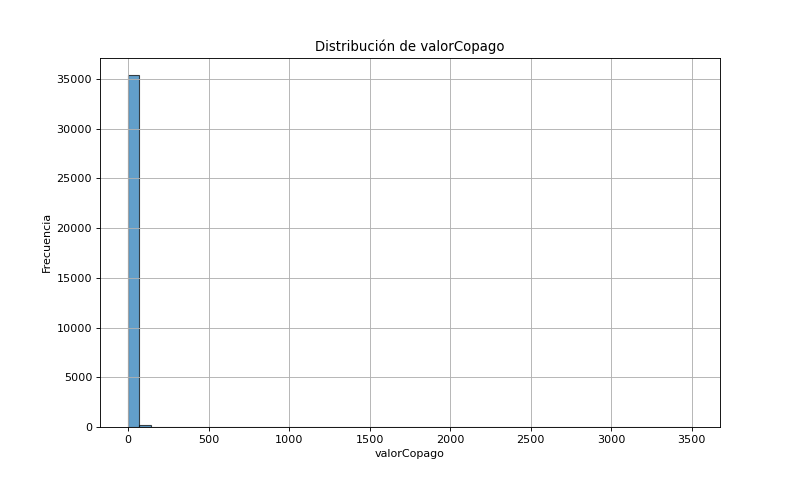

<IPython.core.display.Javascript object>


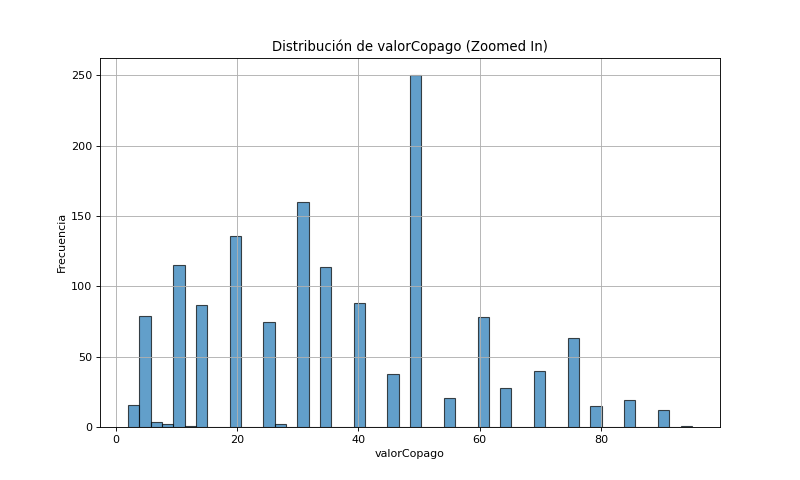

<IPython.core.display.Javascript object>


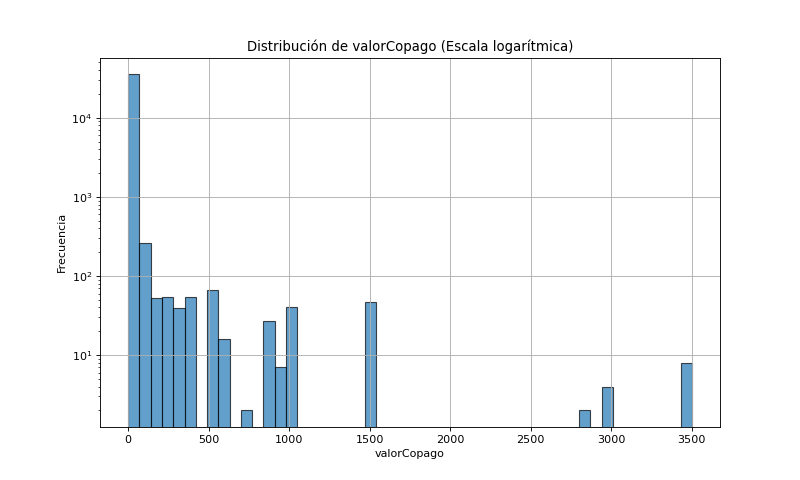

<IPython.core.display.Javascript object>


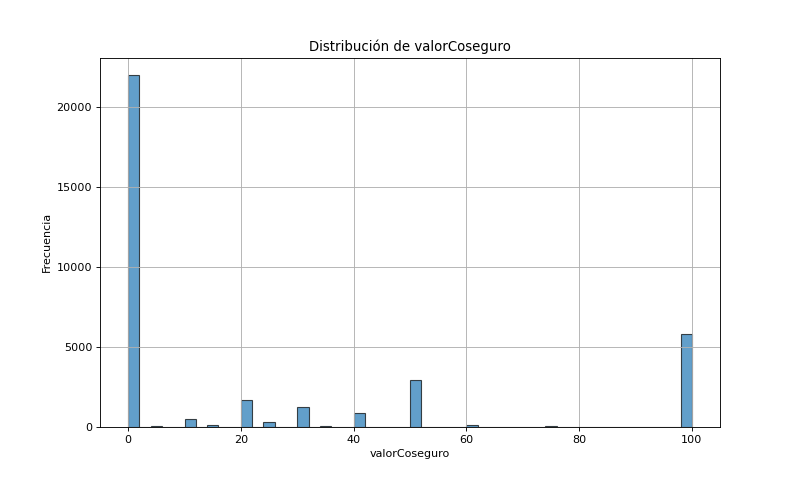

<IPython.core.display.Javascript object>


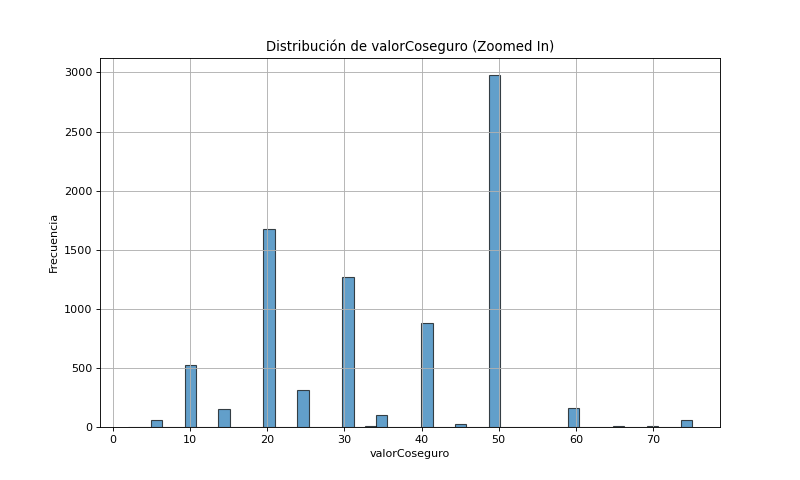

<IPython.core.display.Javascript object>


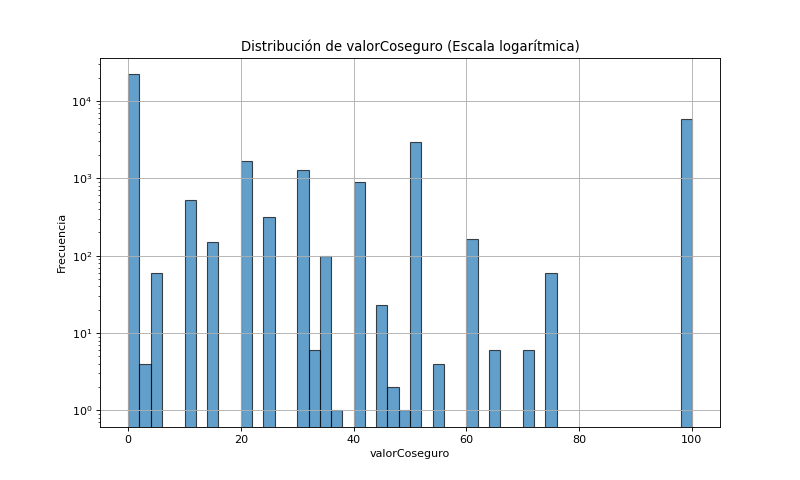

Se puede observar cómo la distribución de 'valorCopago' 
está concentrada en valores pequeños pero contiene valores 
atípicos muy grandes en todo el eje x, siendo el caso de 
'valorCoseguro' muy similar, pero menos concentrado en valores pequeños.


In [112]:
import matplotlib.pyplot as plt

def plot_histogram(df, column_name, zoomed_in=False, min_value=None, max_value=None, log_scale=False):
    """
    Graficar un histograma para una columna especificada en un DataFrame.

    Parámetros:
    - df: DataFrame de PySpark
    - column_name: Nombre de la columna a graficar
    - zoomed_in: Si se desea acercar la vista configurando un rango para el eje x
    - min_value: Valor mínimo para el eje x (utilizado cuando zoomed_in es True)
    - max_value: Valor máximo para el eje x (utilizado cuando zoomed_in es True)
    - log_scale: Si se desea utilizar una escala logarítmica para el eje y
    """

    column_list = df.select(column_name).rdd.flatMap(lambda x: x).collect()
    
    # Excluir los valores en null
    column_list = [x for x in column_list if x is not None]
    
    plt.figure(figsize=(10, 6))
    
    if zoomed_in:
        plt.hist([x for x in column_list if min_value < x < max_value], bins=50, edgecolor='black', alpha=0.7)
    else:
        plt.hist(column_list, bins=50, edgecolor='black', alpha=0.7)
    
    plt.title(f'Distribución de {column_name}' + (' (Zoomed In)' if zoomed_in else '') + (' (Escala logarítmica)' if log_scale else ''))
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    
    if log_scale:
        plt.yscale('log')
    
    plt.show()

# Para acercar, establezca zoomed_in=True y especifique min_value y max_value
plot_histogram(movimientosCopia, 'valorCopago')
plot_histogram(movimientosCopia, 'valorCopago', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'valorCopago', log_scale=True)

plot_histogram(movimientosCopia, 'valorCoseguro')
plot_histogram(movimientosCopia, 'valorCoseguro', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'valorCoseguro', log_scale=True)
print(
"""Se puede observar cómo la distribución de 'valorCopago' 
está concentrada en valores pequeños pero contiene valores 
atípicos muy grandes en todo el eje x, siendo el caso de 
'valorCoseguro' muy similar, pero menos concentrado en valores 
pequeños.""")

<IPython.core.display.Javascript object>


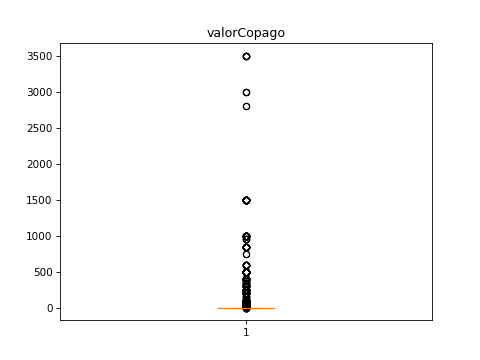

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc790e2c48>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc790e2248>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc79136588>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc7991d248>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc7991d648>],
 'means': []}

In [18]:
fig1, ax1 = plt.subplots()
ax1.set_title('valorCopago')
ax1.boxplot(np.array(movimientosCopia.select('valorCopago').collect()))

<IPython.core.display.Javascript object>


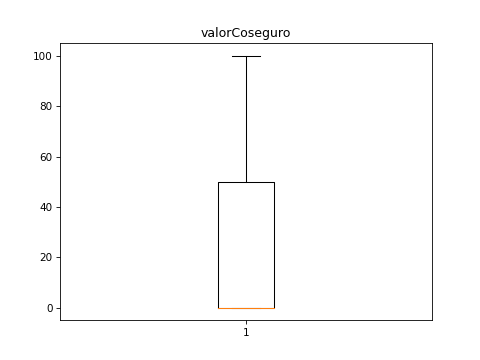

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc797e4188>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc798dd488>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc77167bc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc79902808>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc798d63c8>],
 'means': []}

In [19]:
fig1, ax1 = plt.subplots()
ax1.set_title('valorCoseguro')
ax1.boxplot(np.array(movimientosCopia.select('valorCoseguro').collect()))

<IPython.core.display.Javascript object>


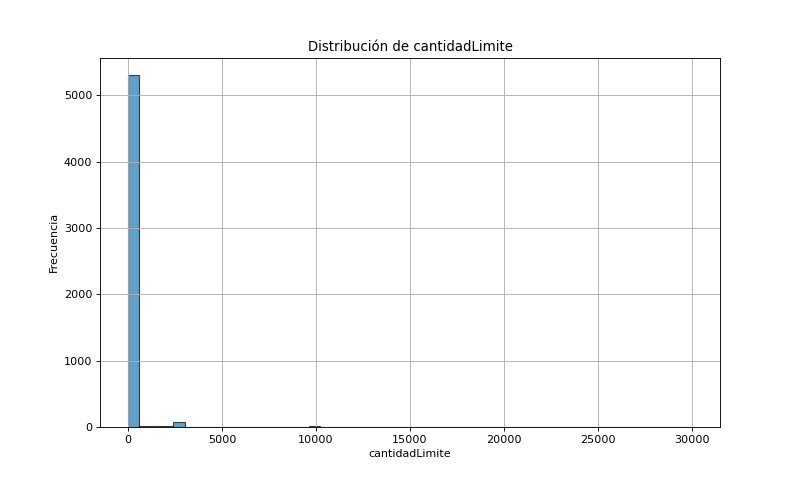

<IPython.core.display.Javascript object>


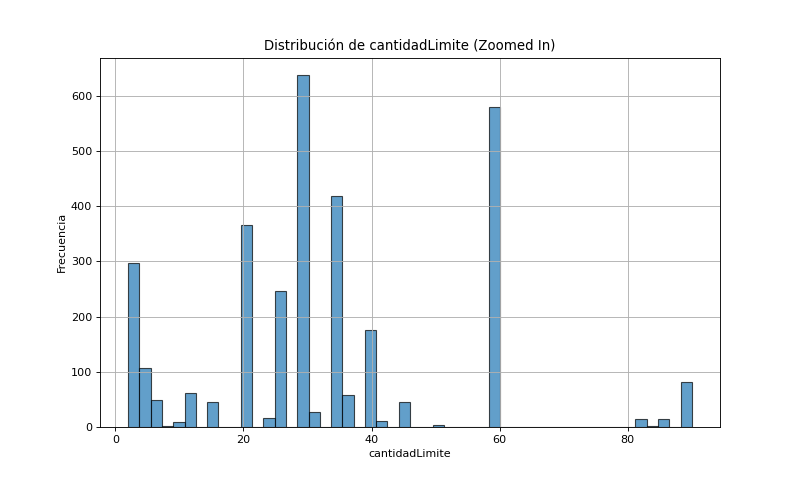

<IPython.core.display.Javascript object>


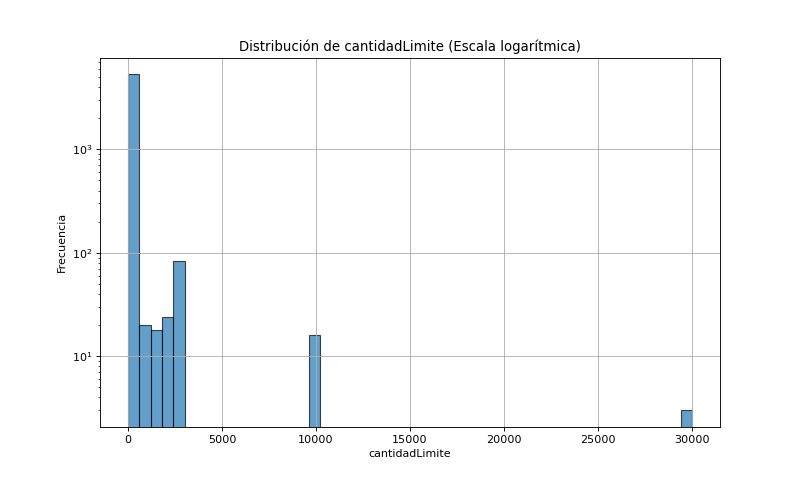


    En el caso de cantidadLimite, se observa que los valores 
    están principalmente concentrados en valores por debajo 
    de 2500, pero hay una gran cantidad de valores atípicos. 



In [113]:
plot_histogram(movimientosCopia, 'cantidadLimite')
plot_histogram(movimientosCopia, 'cantidadLimite', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'cantidadLimite', log_scale=True) 

print(
"""
    En el caso de cantidadLimite, se observa que los valores 
    están principalmente concentrados en valores por debajo 
    de 2500, pero hay una gran cantidad de valores atípicos. 
""")

<IPython.core.display.Javascript object>


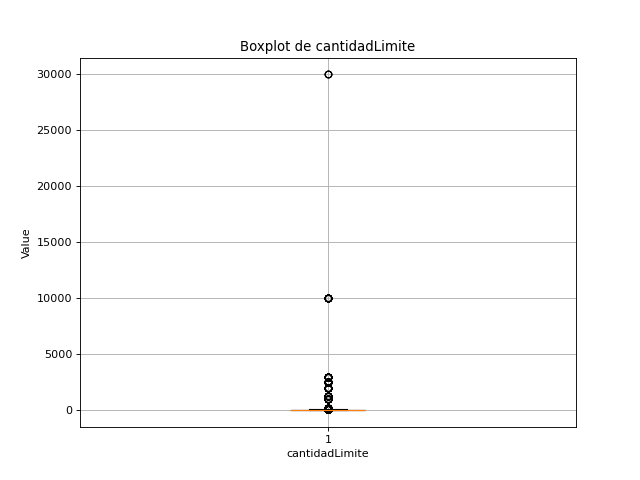

In [114]:
cantidadLimite_values = movimientosCopia.select('cantidadLimite').rdd.flatMap(lambda x: x).collect()

# Excluyendo los valores en null 
cantidadLimite_values = [x for x in cantidadLimite_values if x is not None]

# Creación del boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(cantidadLimite_values)
plt.title('Boxplot de cantidadLimite')
plt.xlabel('cantidadLimite')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Número total de filas: 36036
Número de filas con valores vacíos en columnas de tipo string: 2053
Porcentaje de filas duplicadas: 0.7643190143190143


<IPython.core.display.Javascript object>


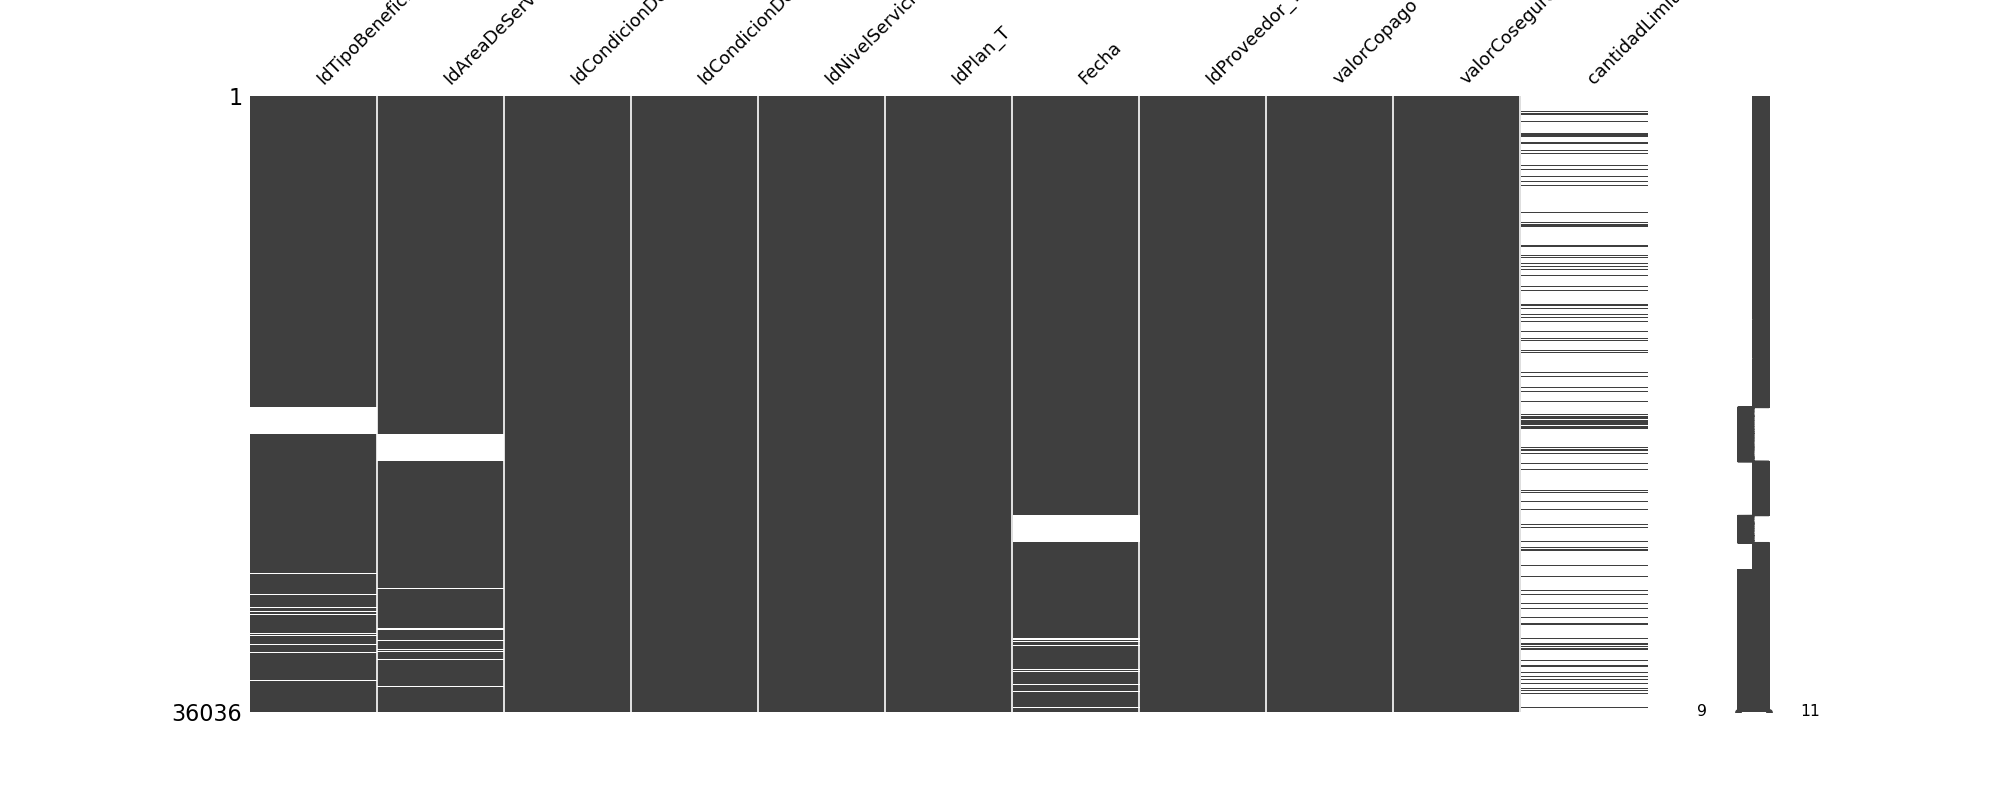

<AxesSubplot:>

In [115]:
import missingno as msno

# Número total de filas
print(f"Número total de filas: {movimientosCopia.count()}")

# Número de filas con valores vacíos en columnas de tipo string
print(f"Número de filas con valores vacíos en columnas de tipo string: {contar_vacios_str(movimientosCopia, False)[0]}")

# Porcentaje de filas duplicadas en relación al total
print(f"Porcentaje de filas duplicadas: {movimientosCopia.distinct().count() / movimientosCopia.count()}")

# Patrones de completitud de datos
msno.matrix(movimientosCopia.toPandas())


In [117]:
missing_percentage = movimientosCopia.toPandas().isnull().mean() * 100

for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}% faltante") 
    
print(
"""
*** ¿Por qué las columnas con 'IdTipoBeneficio_T' son nulas? 
¿Quizás estos planes no tenían ningún beneficio? Lo mismo 
ocurre con 'IdAreaDeServicio_T.'
""")

IdTipoBeneficio_T: 5.79% faltante
IdAreaDeServicio_T: 5.66% faltante
IdCondicionDePagoCopago_T: 0.00% faltante
IdCondicionDePagoCoseguro_T: 0.00% faltante
IdNivelServicio_T: 0.00% faltante
IdPlan_T: 0.00% faltante
Fecha: 5.71% faltante
IdProveedor_T: 0.00% faltante
valorCopago: 0.00% faltante
valorCoseguro: 0.00% faltante
cantidadLimite: 84.83% faltante

*** ¿Por qué las columnas con 'IdTipoBeneficio_T' son nulas? 
¿Quizás estos planes no tenían ningún beneficio? Lo mismo 
ocurre con 'IdAreaDeServicio_T.'



In [119]:
df_summary = movimientosCopia.describe()

# Contando los valores únicos
unique_counts = {
    'IdTipoBeneficio_T': movimientosCopia.select('IdTipoBeneficio_T').distinct().count(),
    'IdAreaDeServicio_T': movimientosCopia.select('IdAreaDeServicio_T').distinct().count(),
    'IdCondicionDePagoCopago_T': movimientosCopia.select('IdCondicionDePagoCopago_T').distinct().count(),
    'IdCondicionDePagoCoseguro_T': movimientosCopia.select('IdCondicionDePagoCoseguro_T').distinct().count(),
    'IdNivelServicio_T': movimientosCopia.select('IdNivelServicio_T').distinct().count(),
    'IdPlan_T': movimientosCopia.select('IdPlan_T').distinct().count(),
    'Fecha': movimientosCopia.select('Fecha').distinct().count(),
    'IdProveedor_T': movimientosCopia.select('IdProveedor_T').distinct().count(),
    'valorCopago': movimientosCopia.select('valorCopago').distinct().count(),
    'valorCoseguro': movimientosCopia.select('valorCoseguro').distinct().count(),
    'cantidadLimite': movimientosCopia.select('cantidadLimite').distinct().count(),
}

# Date range 
date_range = movimientosCopia.agg(
    functions.min('Fecha').alias('Fecha Minima'),
    functions.max('Fecha').alias('Fecha Maxima')
)

print("Valores únicos de cada columna: ") 
print(unique_counts) 
print("Rango de fechas: ") 
date_range.show() 

Valores únicos de cada columna: 
{'IdTipoBeneficio_T': 286, 'IdAreaDeServicio_T': 6497, 'IdCondicionDePagoCopago_T': 14, 'IdCondicionDePagoCoseguro_T': 5, 'IdNivelServicio_T': 3, 'IdPlan_T': 393, 'Fecha': 4, 'IdProveedor_T': 125, 'valorCopago': 49, 'valorCoseguro': 25, 'cantidadLimite': 42}
Rango de fechas: 
+------------+------------+
|Fecha Minima|Fecha Maxima|
+------------+------------+
|  1920-12-31|  2018-12-31|
+------------+------------+



<IPython.core.display.Javascript object>


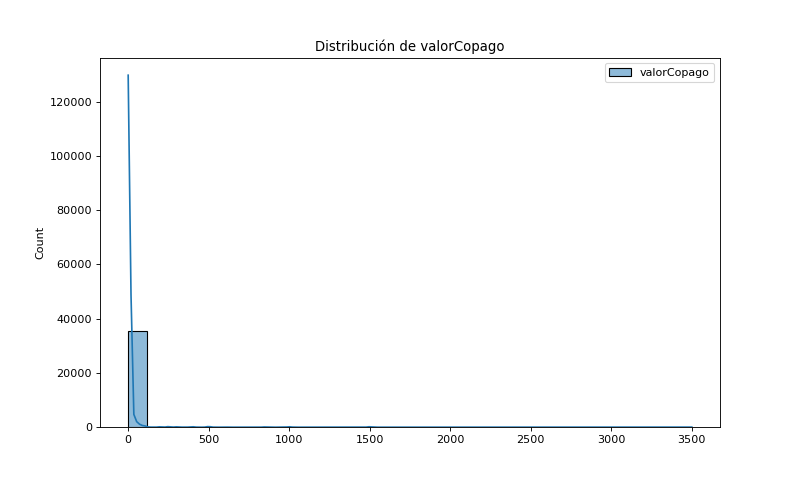

<IPython.core.display.Javascript object>


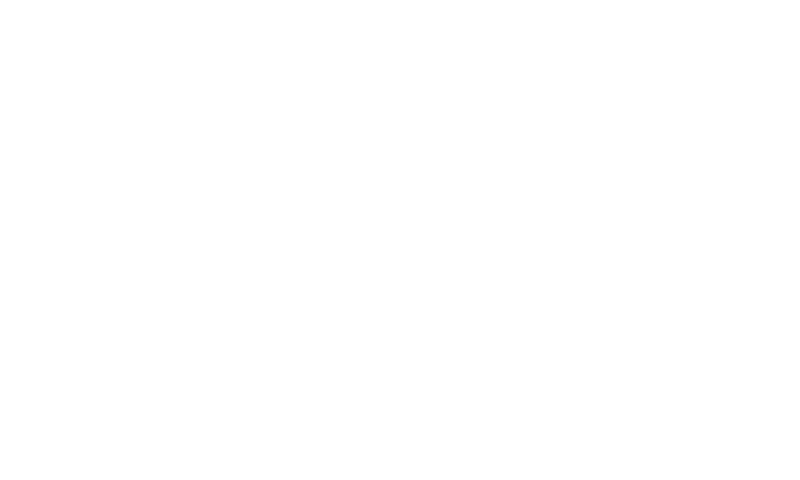

ValueError: Could not interpret input 'Conteo'

In [121]:
import pandas as pd 
import seaborn as sns 
# 1. Distribución de `Cantidad`
df_cantidad = movimientosCopia.select("valorCopago").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_cantidad, bins=30, kde=True)
plt.title('Distribución de valorCopago')
plt.show()

# 3. Top de los planes 
df_product = movimientosCopia.groupBy('IdPlan_T').count().sort('count', ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_product, x='IdPlan_T', y='Conteo')
plt.title('Top 10 Planes')
plt.show() 

print(
"""
Parece que el plan '40047MI0070001-00' 
es el más utilizado con mayor frecuencia, 
seguido de '91762NJ0070093-00'.
""")

## Análisis de calidad de datos

### Tabla FuentePlanesBeneficio_Copia_E

##### Unicidad 

In [122]:
print(f"Number of distinct rows: {movimientosCopia.distinct().count()}")
print(f"Number of total rows: {movimientosCopia.count()}") 

print(
""" 
Uno podría pensar que cada valor en esta tabla es único y diferente, 
pero según el análisis anterior, hay algunos valores duplicados. Por 
lo tanto, la unicidad no se cumple. Además, ¿por qué algunos planes 
se repiten pero con atributos diferentes? Por ejemplo, el plan 
38345WI0080018-03. 
""")
print(
"""
En términos de validez, las fechas no tienen un formato único en su 
totalidad, al igual que existen campos vacíos que podrían ser 
importantes, como IdTipoBeneficio_T e IdAreaDeServicio_T, que podrían 
ser importantes para alguna verificación cruzada de información o 
análisis posterior. 
""")

Number of distinct rows: 27543
Number of total rows: 36036
 
Uno podría pensar que cada valor en esta tabla es único y diferente, 
pero según el análisis anterior, hay algunos valores duplicados. Por 
lo tanto, la unicidad no se cumple. Además, ¿por qué algunos planes 
se repiten pero con atributos diferentes? Por ejemplo, el plan 
38345WI0080018-03. 


En términos de validez, las fechas no tienen un formato único en su 
totalidad, al igual que existen campos vacíos que podrían ser 
importantes, como IdTipoBeneficio_T e IdAreaDeServicio_T, que podrían 
ser importantes para alguna verificación cruzada de información o 
análisis posterior. 



##### Completitud y validez

In [123]:
print("NULL valores: ")
empty_columns_movimientosCopia = contar_vacios(movimientosCopia) 
print("'' valores: ")
empty_columns_movimientosCopia_str = contar_vacios_str(movimientosCopia)

print("\n Cardinalidad")
movimientosCopia_c = cardinalidad(movimientosCopia) 
print(f"{movimientosCopia_c}") 

print(
"""\n
Al verificar las columnas con valores vacíos, solo IdPlan_T tiene columnas con datos faltantes, lo que probablemente sea la columna más importante aquí. Sería necesario consultar con el cliente si esto es aceptable, ya que parece importante tener el valor de IdPlan_T.

En cuanto a la cardinalidad, ninguna de las columnas aquí tiene una cardinalidad alta, lo que significa que las columnas de identificación tienen varios duplicados.

IdTipoBeneficio_T tiene 2086 valores nulos.
IdAreaDeServicio_T tiene 2041 valores nulos.
Fecha tiene 2056 valores nulos.
cantidadLimite tiene 30571 valores nulos.
""")

NULL valores: 
número de vacíos para columna IdTipoBeneficio_T: 2086
número de vacíos para columna IdAreaDeServicio_T: 2041
número de vacíos para columna Fecha: 2056
número de vacíos para columna cantidadLimite: 30571
'' valores: 
Number of "" values for column IdPlan_T: 2053

 Cardinalidad
{}


Al verificar las columnas con valores vacíos, solo IdPlan_T tiene columnas con datos faltantes, lo que probablemente sea la columna más importante aquí. Sería necesario consultar con el cliente si esto es aceptable, ya que parece importante tener el valor de IdPlan_T.

En cuanto a la cardinalidad, ninguna de las columnas aquí tiene una cardinalidad alta, lo que significa que las columnas de identificación tienen varios duplicados.

IdTipoBeneficio_T tiene 2086 valores nulos.
IdAreaDeServicio_T tiene 2041 valores nulos.
Fecha tiene 2056 valores nulos.
cantidadLimite tiene 30571 valores nulos.



##### Validez

In [124]:
print("""
Esta regla se verificó al validar la regla de negocio "El valor máximo de Copago y Coseguro para el año 2018 es respectivamente de 3300 y 100", donde se comprobaron algunas fechas con los meses en palabras en lugar de números, por ejemplo, "Dec 31, 2017" o "Dec 31, 2018".

Existen valores nulos en cantidadLimite, pero aún no sabemos si esto es aceptable.
""")


Esta regla se verificó al validar la regla de negocio "El valor máximo de Copago y Coseguro para el año 2018 es respectivamente de 3300 y 100", donde se comprobaron algunas fechas con los meses en palabras en lugar de números, por ejemplo, "Dec 31, 2017" o "Dec 31, 2018".

Existen valores nulos en cantidadLimite, pero aún no sabemos si esto es aceptable.



##### Consistencia¶

In [125]:
distinct_dates = movimientosCopia.filter(col("fecha") <= '1990-01-01').select("fecha").distinct()

# Mostrar las fechas diferentes 
distinct_dates.show() 

filtered_df_cop = FuenteCondicionesDePago_Copia_E.filter(FuenteCondicionesDePago_Copia_E.Tipo == 'Copago')
filtered_df_cos = FuenteCondicionesDePago_Copia_E.filter(FuenteCondicionesDePago_Copia_E.Tipo == 'Coseguro')

# Seleccione distintas 'IdCondicionesDePago_T' y recopile los resultados como una lista
ids_condiciones_Copago = list(set(filtered_df_cop.select('IdCondicionesDePago_T').rdd.flatMap(lambda x: x).collect()))
ids_condiciones_Coseguro = list(set(filtered_df_cos.select('IdCondicionesDePago_T').rdd.flatMap(lambda x: x).collect()))

ids_areas_servicio = set([x.IdAreaDeServicio_T for x in FuenteAreasDeServicio_Copia_E.select('IdAreaDeServicio_T').collect()])
ids_beneficios = set([x.IdTipoBeneficio_T for x in FuenteTiposBeneficio_Copia_E.select('IdTipoBeneficio_T').collect()]) 

hechos_ids_areas_servicio = set([x.IdAreaDeServicio_T for x in movimientosCopia.select('IdAreaDeServicio_T').collect()])
hechos_ids_condiciones_Copago = set([x.IdCondicionDePagoCopago_T for x in movimientosCopia.select('IdCondicionDePagoCopago_T').collect()])
hechos_ids_condiciones_Coseguro = set([x.IdCondicionDePagoCoseguro_T for x in movimientosCopia.select('IdCondicionDePagoCoseguro_T').collect()])
hechos_ids_beneficios = set([x.IdTipoBeneficio_T for x in movimientosCopia.select('IdTipoBeneficio_T').collect()])

print("ids_areas_servicio")
print(len(ids_areas_servicio), len(hechos_ids_areas_servicio)-2041)
print("ids_condiciones_Copago")
print(len(ids_condiciones_Copago), len(hechos_ids_condiciones_Copago)) 
print("ids_condiciones_Coseguro")
print(len(ids_condiciones_Coseguro), len(hechos_ids_condiciones_Coseguro)) 
print("ids_beneficios")
print(len(ids_beneficios), len(hechos_ids_beneficios)) 

print(
"""    
*** ¿Por qué existen planes con fechas desde el 31 de diciembre de 1920?

*** ¿Por qué hay valores nulos en cantidadLimite?

*** ¿Por qué existen ids_beneficios que no están en la tabla IdTipoBeneficio_T? Por ejemplo, 2090, 1450, 1890.
# """)

+----------+
|     fecha|
+----------+
|1920-12-31|
+----------+

ids_areas_servicio
5410 4456
ids_condiciones_Copago
14 14
ids_condiciones_Coseguro
5 5
ids_beneficios
178 286
    
*** ¿Por qué existen planes con fechas desde el 31 de diciembre de 1920?

*** ¿Por qué hay valores nulos en cantidadLimite?

*** ¿Por qué existen ids_beneficios que no están en la tabla IdTipoBeneficio_T? Por ejemplo, 2090, 1450, 1890.
# 


### Tabla FuenteAreasDeServicio_Copia_E

In [133]:
summary_df = FuenteAreasDeServicio_Copia_E.summary()
# Convierte el DataFrame de resumen a un DataFrame de Pandas
summary_pandas_df = summary_df.toPandas()
# Muestra el DataFrame de Pandas como una tabla en Jupyter Notebook
summary_pandas_df

,summary,IdAreaDeServicio_T,NombreAreaDeServicio,IdGeografia_T,Condado,Estado,PoblacionAct,Area,Densidad,Fecha
0,count,182527,188815,182437,188815,188815,188815,186408,186408,188815
1,mean,5.5661602010935366E7,None,42946.06266820875,None,None,4.147959051463602E7,770.9518851122269,276.0979410754903,2010.2215554908244
2,stddev,3.0402410466496132E7,None,32489.478070072095,None,None,5.943835931334065E8,1263.4887340485252,851.3219978151402,39.00236181529916
3,min,12018,AZ Statewide12303AZ0010001-01201774,1001,Abbeville County,Alabama,82.0,-24707.0,0.0,1800
4,25%,33432017,None,21035,None,None,12538.0,400.0,20.0,2017
5,50%,50762018,None,35051,None,None,30885.0,575.0,51.0,2017
6,75%,82702018,None,51149,None,None,110686.0,870.0,170.0,2018
7,max,117872018,Wyoming11269WY0080014-00201710379,168135,Ziebach County,Wyoming,4.72803E10,88824.0,14946.0,2018


In [134]:
print(
"""
\n
IdAreaDeServicio_T tiene valores muy grandes en promedio y una gran desviación estándar, lo que indica una amplia variación en los números de identificación de las áreas de servicio.
IdGeografia_T también tiene una amplia variación, lo que podría indicar una amplia gama de geografías cubiertas.
PoblacionAct tiene un promedio extremadamente alto debido a algún(os) valor(es) extremadamente grande(s), como se ve en el valor máximo, lo cual es indicativo de un posible error o valor atípico.
Area y Densidad también tienen valores atípicos extremos, lo que se evidencia en sus máximos y la gran desviación estándar.
La columna Fecha tiene un rango desde 1800 hasta 2018, lo cual es muy amplio y sugiere que los datos pueden incluir valores históricos.
Es crucial revisar los valores extremos y atípicos, especialmente en las columnas PoblacionAct, Area y Densidad, ya que pueden afectar significativamente el análisis estadístico y los resultados de cualquier modelo de datos.
""")




IdAreaDeServicio_T tiene valores muy grandes en promedio y una gran desviación estándar, lo que indica una amplia variación en los números de identificación de las áreas de servicio.
IdGeografia_T también tiene una amplia variación, lo que podría indicar una amplia gama de geografías cubiertas.
PoblacionAct tiene un promedio extremadamente alto debido a algún(os) valor(es) extremadamente grande(s), como se ve en el valor máximo, lo cual es indicativo de un posible error o valor atípico.
Area y Densidad también tienen valores atípicos extremos, lo que se evidencia en sus máximos y la gran desviación estándar.
La columna Fecha tiene un rango desde 1800 hasta 2018, lo cual es muy amplio y sugiere que los datos pueden incluir valores históricos.
Es crucial revisar los valores extremos y atípicos, especialmente en las columnas PoblacionAct, Area y Densidad, ya que pueden afectar significativamente el análisis estadístico y los resultados de cualquier modelo de datos.



### Tabla FuenteCondicionesDePago_Copia_E 

In [130]:
print(f"Numero diferentes de Id: {FuenteCondicionesDePago_Copia_E.select('IdCondicionesDePago_T').distinct().count()}")
print(f"Id_s que se repiten:")
FuenteCondicionesDePago_Copia_E.groupBy("IdCondicionesDePago_T").count().orderBy("count", ascending=False).show()

Numero diferentes de Id: 23
Id_s que se repiten:
+---------------------+-----+
|IdCondicionesDePago_T|count|
+---------------------+-----+
|                  204|    3|
|                  221|    2|
|                  207|    2|
|                  119|    2|
|                   27|    2|
|                   51|    2|
|                   45|    2|
|                   85|    1|
|                   34|    1|
|                    9|    1|
|                  714|    1|
|                  663|    1|
|                  238|    1|
|                  136|    1|
|                  170|    1|
|                   68|    1|
|                  153|    1|
|                   17|    1|
|                  102|    1|
|                  135|    1|
+---------------------+-----+
only showing top 20 rows



#### Unicidad 

In [131]:
print("La base contiene 31 registros pero, 7 de ellos presentan duplicados, donde 6 se repiten 2 veces y 1 Id se encuentra en más de 3 ocasiones.")

La base contiene 31 registros pero, 7 de ellos presentan duplicados, donde 6 se repiten 2 veces y 1 Id se encuentra en más de 3 ocasiones.


### Tabla FuenteTiposBeneficio_Copia_E

In [128]:
# Suponiendo que tienes un DataFrame llamado "FuenteTiposBeneficio_Copia_E"
FuenteTiposBeneficio_Copia_E_df = FuenteTiposBeneficio_Copia_E.summary() 

# Convierte el DataFrame de resumen a un DataFrame de Pandas
FuenteTiposBeneficio_Copia_E_df_pandas_df = FuenteTiposBeneficio_Copia_E_df.toPandas()

# Muestra el DataFrame de Pandas como una tabla en Jupyter Notebook
FuenteTiposBeneficio_Copia_E_df_pandas_df

,summary,IdTipoBeneficio_T,Nombre,UnidadDelLimite,EsEHB,EstaCubiertaPorSeguro,TieneLimiteCuantitativo,ExcluidoDelDesembolsoMaximoDentroDeLaRed,ExcluidoDelDesembolsoMaximoFueraDeLaRed,Fecha
0,count,849,849,849,849,849,849,849,849,849
1,mean,504.62308598351,None,None,None,None,None,None,None,2017.208480565371
2,stddev,305.0836557627739,None,None,None,None,None,None,None,0.40646157760308743
3,min,5,Abortion for Which Public Funding is Prohibited,,No,False,Nein,Algunas veces,No,2017
4,25%,220,None,None,None,None,None,None,None,2017
5,50%,510,None,None,None,None,None,None,None,2017
6,75%,790,None,None,None,None,None,None,None,2017
7,max,1055,X-rays and Diagnostic Imaging,Visit(s) per year,Yes,Yes,Yes,Yes,Yes,2018


In [137]:
elementos_unicos = FuenteTiposBeneficio_Copia_E.select("TieneLimiteCuantitativo").distinct()
elementos_unicos.show() 

+-----------------------+
|TieneLimiteCuantitativo|
+-----------------------+
|                   Nein|
|                     No|
|                    Yes|
|                     Si|
+-----------------------+



<IPython.core.display.Javascript object>


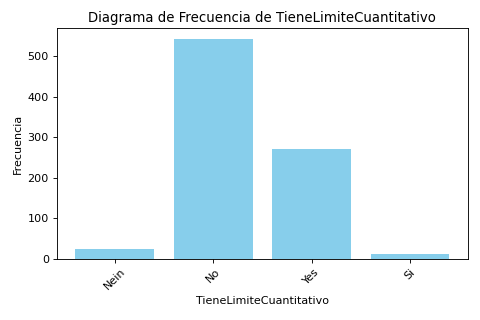

In [129]:
frecuencias = FuenteTiposBeneficio_Copia_E.groupBy("TieneLimiteCuantitativo").count()
frecuencias_pd = frecuencias.toPandas()
plt.figure(figsize=(6, 4))
plt.bar(frecuencias_pd['TieneLimiteCuantitativo'], frecuencias_pd['count'], color='skyblue')
plt.xlabel('TieneLimiteCuantitativo')
plt.ylabel('Frecuencia')
plt.title('Diagrama de Frecuencia de TieneLimiteCuantitativo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


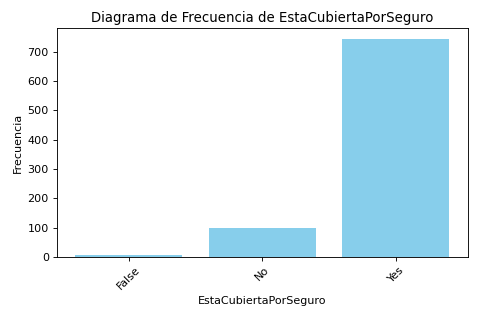

In [135]:
frecuencias = FuenteTiposBeneficio_Copia_E.groupBy("EstaCubiertaPorSeguro").count()
frecuencias_pd = frecuencias.toPandas()
plt.figure(figsize=(6, 4))
plt.bar(frecuencias_pd['EstaCubiertaPorSeguro'], frecuencias_pd['count'], color='skyblue')
plt.xlabel('EstaCubiertaPorSeguro')
plt.ylabel('Frecuencia')
plt.title('Diagrama de Frecuencia de EstaCubiertaPorSeguro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusiones

In [ ]:

**Conclusiones generales:**
1. Se esperaba que tabla hechos tuviera registros únicos por cada plan, pero parece que los planes se repiten, por lo que es 
ideal consultar con el cliente este suceso y enclarecer si es un error o algo normal. 
2. Hay 

    
**Conclusiones de reglas de negocio:**


    
**Conclusiones de calidad:** 
1. Hay fechas de planes de 1920 y parecen ser la única fecha antigua, por lo que no sabemos a qué se podrá deber. Hay que 
consultar con el cliente. 
2. Hay fechas desde 1800 hasta 2018 en la tabla de Áreas de servicio relacionadas con la fecha de creación del área de servicio. 
Hay que consultar con el cliente. 
3. Hay múltiples respuestas en diferentes idiomas y formatos en la tabla de Tipos de Beneficios en casi todos campos. Se 
observa esta misma condición en la tabla de Condiciones de Pago. Se debe de consultar con el cliente para saber si se 
normalizan las respuestas a un idioma de parte nuestra. 
4. En la tabla de Condiciones de Pago, las variables de Tipo y Descripción se esperaría que tuvieran una relación muy cercana 
ya que debería existir una coherencia al comparar su contenido. 
5. En la tabla de Áreas de servicio hay valores de área negativos y NULL.  
6. Los valores mínimos en valorCoseguro y valorCopago cuando alguno de estos es 0, el otro también lo es
7. Parece que 'cantidadLimite' tiene un alto número de valores nulos. ¿Esta condición se debe a algunos planes que no 
tienen ningún límite en su cantidad? 
8. ¿Por qué las columnas con 'IdTipoBeneficio_T' son nulas? ¿Quizás estos planes no tenían ningún beneficio? Lo mismo 
ocurre con 'IdAreaDeServicio_T.' 
9. Uno podría pensar que cada valor en esta tabla es único y diferente, pero según el análisis anterior, hay algunos valores 
duplicados. Por lo tanto, la unicidad no se cumple. Además, ¿por qué algunos planes se repiten pero con atributos diferentes? 
Por ejemplo, el plan 38345WI0080018-03.  
10. Uno podría pensar que cada valor en esta tabla es único y diferente, pero según el análisis anterior, hay algunos valores 
duplicados. Por lo tanto, la unicidad no se cumple. Además, ¿por qué algunos planes se repiten pero con atributos diferentes? 
Por ejemplo, el plan 38345WI0080018-03. (Tabla Hechos)   
11. Al verificar las columnas con valores vacíos, solo IdPlan_T tiene columnas con datos faltantes, lo que probablemente sea 
la columna más importante aquí. Sería necesario consultar con el cliente si esto es aceptable, ya que parece importante tener 
el valor de IdPlan_T. 
12. ¿Por qué hay valores nulos en cantidadLimite? 
13. ¿Por qué existen ids_beneficios que no están en la tabla IdTipoBeneficio_T? Por ejemplo, 2090, 1450, 1890.

**Usando herramientas:**
1. Se puede observar cómo la distribución de 'valorCopago' está concentrada en valores pequeños pero contiene valores 
atípicos muy grandes en todo el eje x, siendo el caso de 'valorCoseguro' muy similar, pero menos concentrado en valores 
pequeños.
2. Además, ¿por qué hay valores de 0 en 'valorCopago' y 'valorCoseguro' cuando algunos de ellos son 0, es decir, el valor 
mínimo de 'valorCoseguro' cuando 'valorCoseguro' = 0 es 0, y viceversa?
3. En el caso de cantidadLimite, se observa que los valores están principalmente concentrados en valores por debajo 
de 2500, pero hay una gran cantidad de valores atípicos.
4. Parece que el plan '40047MI0070001-00' es el más utilizado con mayor frecuencia, seguido de '91762NJ0070093-00'. 

Sección de variables del reporte: 
1.Esta tabla muestra un resumen estadístico de un DataFrame obtenido de PySpark. Aquí hay comentarios descriptivos para 
cada parte del resumen:

2. count (Recuento): En esta fila, se muestra el recuento de valores no nulos para cada columna. Por ejemplo, hay 33,950 
valores no nulos en la columna "IdTipoBeneficio_T".

3. mean (Media): Esta fila muestra la media o promedio de los valores en cada columna numérica. Por ejemplo, la media de 
"IdTipoBeneficio_T" es aproximadamente 584.50.

4. stddev (Desviación estándar): Esta fila muestra la desviación estándar de los valores en cada columna numérica, que 
indica la dispersión de los datos con respecto a la media. Por ejemplo, la desviación estándar de "IdTipoBeneficio_T" 
es aproximadamente 389.11.

5. min (Mínimo): Muestra el valor mínimo encontrado en cada columna numérica. Por ejemplo, el valor mínimo en la columna 
"IdTipoBeneficio_T" es 5.

6. 25% (Percentil 25): Este valor representa el percentil 25 de los datos, es decir, el valor por debajo del cual cae el 
25% de los datos. Por ejemplo, en la columna "IdTipoBeneficio_T", el 25% de los datos es igual o menor a 275.

7. 50% (Percentil 50 o Mediana): Representa el valor mediano en los datos, dividiendo los datos en dos partes iguales. Por 
ejemplo, en la columna "IdTipoBeneficio_T", el valor mediano es 565.

8. 75% (Percentil 75): Indica el percentil 75 de los datos, es decir, el valor por debajo del cual cae el 75% de los datos. 
Por ejemplo, en la columna "IdTipoBeneficio_T", el 75% de los datos es igual o menor a 820.

9. max (Máximo): Muestra el valor máximo encontrado en cada columna numérica. Por ejemplo, el valor máximo en la columna 
"IdTipoBeneficio_T" es 2110.

10. Este resumen estadístico proporciona información importante sobre la distribución y estadísticas básicas de las columnas 
en el DataFrame, lo que puede ser útil para comprender los datos y tomar decisiones basadas en ellos.

11. En cuanto a la tabla de hechos: 
IdTipoBeneficio_T tiene 2086 valores nulos.
IdAreaDeServicio_T tiene 2041 valores nulos.
Fecha tiene 2056 valores nulos.
cantidadLimite tiene 30571 valores nulos.


## Justificación de si es posible resolver los análisis basados en tableros de control propuestos.

#### Comportamiento desleal de proveedores

Este análisis se puede hacer pero sería muy vago debido a la falta de una tabla de dimensión de "Proveedores", además de que parece que un beneficio se presenta en la tabla de los hechos con diferentes tipos de Copago y Coseguro, por lo que esto podría afectar el valor del cobro de estos campos, lo que haría que este análisis fuera insuficiente. Se aconsejaría que nos brinden la información de los proveedores y extender este análisis a la inclusión de los tipos de Copago y Coseguro para ver si son desleales completamente. Además, hay que aclarar el porqué hay IDs de beneficios que están en la tabla FuentePlanesBeneficio_Copia_E pero no en la FuenteTiposBeneficio_Copia_E.

#### Cobertura de planes

Este análisis se puede lograr ya que se tiene la información necesaria, tales como los planes, las fechas, las áreas de servicio y los identificadores de los proveedores. Cabe aclarar que, como el anterior análisis, no se podría dar observaciones completas y coherentes por las fechas mal tratas y la falta de información de los proveedores. 

#### Concentraciones de planes

Este análisis necesita grandes ajustes, tales como un ajuste para se que tenga en cuenta la fecha de la población actual de la tabla FuenteAreasDeServicio_Copia_E y la de los planes, porque puede que en un determinado tiempo hayan existido suficientes planes para sobrepasar la población actual. Además, hay que aclarar si se considera un plan diferente cada registro o por cada valor único correspondiente a la columna IdPlan_T, pues en estos registros se presentan varios filas con el mismo IdPlan_T. 

#### Evolución de planes

Este análisis tiene una situación similar a los anteriores, ya que las fechas no son las más apropiadas o coherentes en muchas de las tablas pero se puede lograr aunque con información incoherente. Además, hay que aclarar el porqué hay IDs de beneficios que están en la tabla FuentePlanesBeneficio_Copia_E pero no en la FuenteTiposBeneficio_Copia_E. Además, ¿por qué hay planes con beneficios fuera de las fechas ofertadas que se muestran en la tabla FuenteTiposBeneficio_Copia_E? 

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
